***Enhancing Trustability and Interpretability of
Deep Learning Models for Brain Tumor
Diagnosis through Bayesian Fine-tuning of
Foundation Models for Medical Imaging***

This project focuses on the application of Bayesian fine-tuning on foundation models for the diagnosis of brain tumors using MRI data. It aims to bridge the gap between the potential of DL models in medical imaging and the practical challenges hindering their adoption in clinical settings as result of their interpretability limitations. 

By integrating Bayesian methods with pre-trained large models like  <a href="https://github.com/Omid-Nejati/MedViT">MedViT</a>, the project seeks to enhance uncertainty quantification and interpretability, and thus increasing trust in AI-driven diagnostics among clinicians, potentially improving patient care by providing more reliable diagnostic tools and informing better clinical decisions.

In [1]:
!conda env list

# conda environments:
#
base                     /opt/conda
pytorch               *  /opt/conda/envs/pytorch



In [2]:
import torch
print(torch.__version__)


2.3.0


In [3]:
#!nvidia-smi

In [4]:
import sys
sys.path.append('/home/ec2-user/ssl')

In [5]:
import sys
import os

print(os.getcwd())

/home/ec2-user/ssl


In [6]:
# Add the path to the MedViT directory
sys.path.append(os.path.join(os.getcwd(), 'MedViT'))

In [7]:
import torch
import torchvision.transforms as transforms
import torchvision
import medmnist
from medmnist import INFO

### Data Processing & Analysis


Dataset preparation

In [9]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator
import torchvision
import torch
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO


The images should be resized to 224x224 (required for MedViT) and converted to RGB since the MedViT model expects RGB input images. We also need to prepare a dataset using a PyTorch DataLoader for efficient processing.

In [10]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Labels and image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 224  # Resize to 224x224 for MedViT
n_classes = len(labels)

# Local directory where the dataset is located
local_data_dir = '/home/ec2-user/ssl/mri_dataset'

# Custom dataset class using PyTorch's Dataset
class MRIDataset(data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, index):
        image_path = self.file_paths[index]
        label = self.labels[index]
        
        image = cv2.imread(image_path, 0)  # Read as grayscale
        if image is None:
            return None, None
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for MedViT
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Function to gather file paths and labels
def get_file_paths_and_labels(phase):
    x_data = []
    y_data = []
    phase_dir = os.path.join(local_data_dir, phase)
    
    for label in labels:
        label_dir = os.path.join(phase_dir, label)
        if not os.path.exists(label_dir):
            continue
        files = os.listdir(label_dir)
        
        for file in files:
            x_data.append(os.path.join(label_dir, file))
            y_data.append(labels.index(label))
    
    return x_data, y_data

# Get file paths and labels for training and testing
x_train_files, y_train = get_file_paths_and_labels('Training')
x_test_files, y_test = get_file_paths_and_labels('Testing')

# Split the original testing set into validation and test sets
x_val_files, x_test_files, y_val, y_test = train_test_split(
    x_test_files, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Define transform with data augmentation for the training set
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(15),  # Rotate the image by a random angle between -15 and 15 degrees
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transform for validation and test sets (no augmentation)
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Dataset instances with the updated transforms
train_dataset = MRIDataset(x_train_files, y_train, transform=train_transform)
val_dataset = MRIDataset(x_val_files, y_val, transform=val_test_transform)
test_dataset = MRIDataset(x_test_files, y_test, transform=val_test_transform)

# Create DataLoader instances
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset information
print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))


Training set size: 5712
Validation set size: 655
Test set size: 656


***Visualizing and Exploring Data***

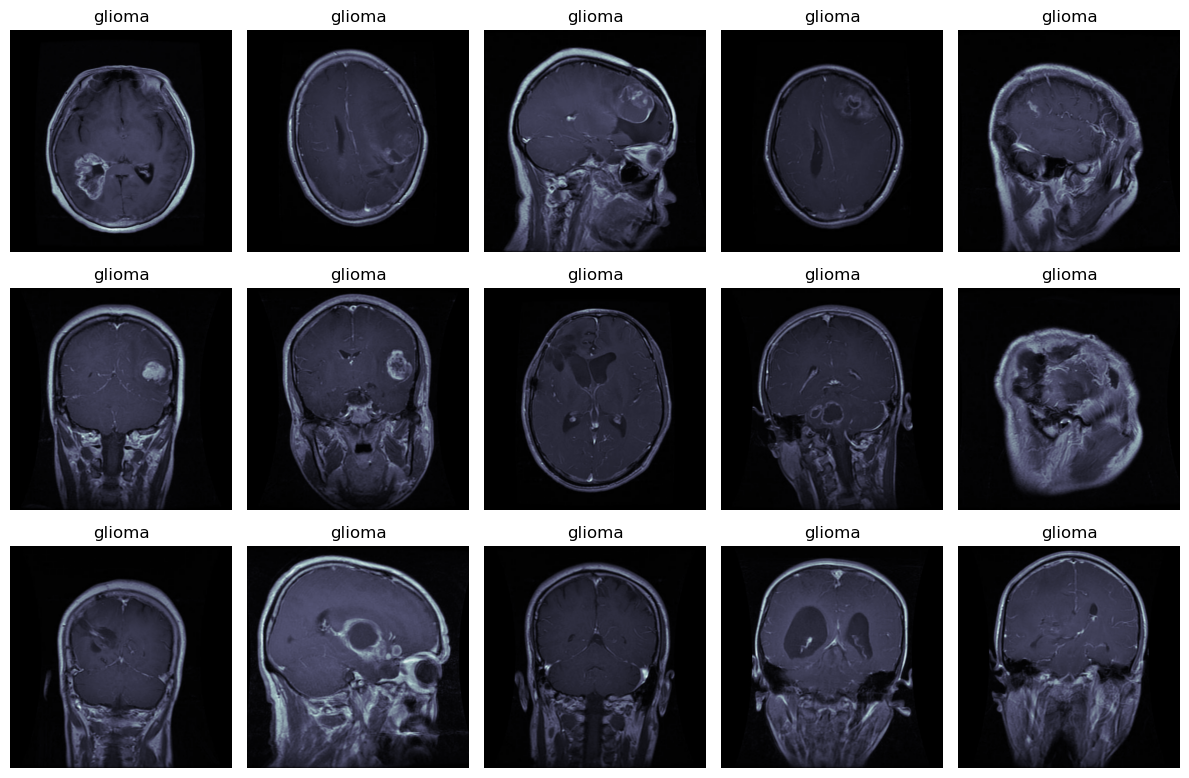

In [11]:
import matplotlib.pyplot as plt
import cv2

# Select some images to visualize
sample_indices = range(15)
images = [cv2.imread(x_train_files[i], cv2.IMREAD_GRAYSCALE) for i in sample_indices]
labels = [y_train[i] for i in sample_indices]

# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()

# Map label indices to label names
label_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Plot each image with its corresponding label
for img, label, ax in zip(images, labels, axes):
    if img is not None:
        img = cv2.bilateralFilter(img, 2, 50, 50)
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)  # Apply the same color map as in data processing
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Convert BGR to RGB for display
        ax.imshow(img_rgb)
        ax.set_title(label_names[label])
        ax.axis('off')
    else:
        ax.set_visible(False)  # Hide the axes if there's no image

plt.tight_layout()
plt.show()


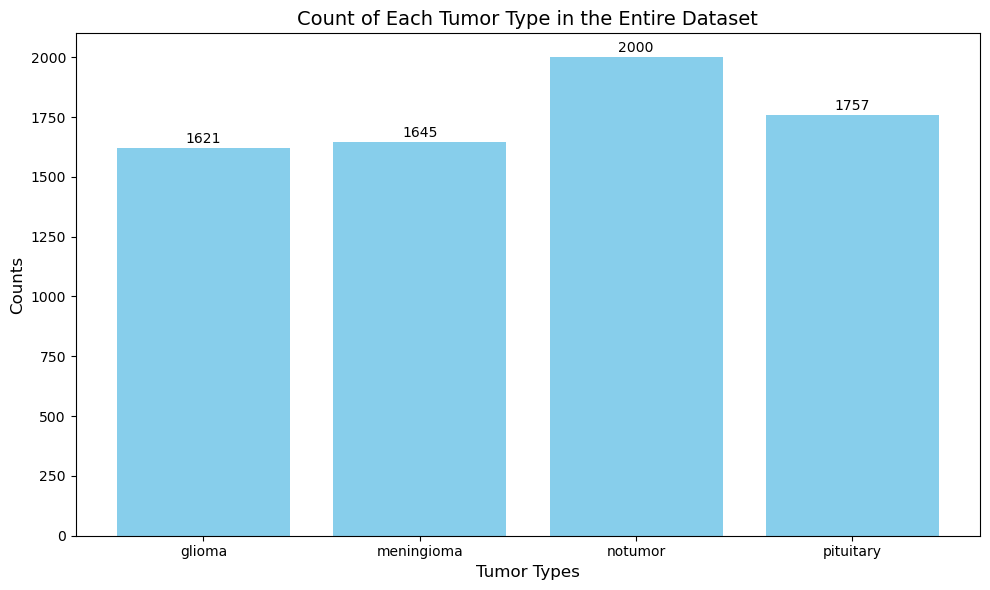

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the labels from the entire dataset
combined_labels = np.concatenate((y_train, y_val, y_test))

# Count the number of each disease
unique_labels, counts = np.unique(combined_labels, return_counts=True)

# Map label indices to label names
label_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
label_names = [label_names[label] for label in unique_labels]

# Visualize the counts in a bar chart
fig = plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, counts, color='skyblue')
plt.title('Count of Each Tumor Type in the Entire Dataset', fontsize=14)
plt.xlabel('Tumor Types', fontsize=12)
plt.ylabel('Counts', fontsize=12)

# Annotate bars with counts
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


As we can see, there is no evidence of significant class imbalance

***Fine Tuning MedViT Model  - No Bayes method yet***

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from MedViT import MedViT_base
import numpy as np
from torch.optim.lr_scheduler import MultiStepLR

# Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_path = '/home/ec2-user/ssl/MedViT/pretrained_weights/MedViT_base.pth'
n_classes = 4
num_epochs = 100
batch_size = 32
patience = 10
num_workers = 4
checkpoint_path = 'medvit_checkpoint_no_bayesdll.pth'

# Function to load the pre-trained MedViT model
def load_pretrained_medvit(weights_path, num_classes):
    print("Loading MedViT model...")
    model = MedViT_base(num_classes=1000).to(device)
    checkpoint = torch.load(weights_path)
    state_dict = checkpoint.get('model', checkpoint)
    state_dict = {k: v for k, v in state_dict.items() if 'proj_head.0' not in k}
    model.load_state_dict(state_dict, strict=False)
    in_features = model.proj_head[0].in_features
    model.proj_head = nn.Linear(in_features, num_classes).to(device)
    print("MedViT model loaded successfully.")
    return model

# Fine-tuning function with checkpointing support and total training time tracking
def fine_tune_model(model, train_loader, val_loader, num_epochs=100, lr=0.0001, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    lr_scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    start_epoch = 0

    # Start the timer for total training time
    total_start_time = time.time()

    # Resuming from checkpoint if exists
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resuming training from epoch {start_epoch + 1}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

        # Validation
        model.eval()
        val_loss, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Checkpointing and early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch + 1}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
                break

        lr_scheduler.step()

    # Total training time
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    print(f"Total training time: {total_duration / 60:.2f} minutes.")

    print("Training completed successfully.")

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(np.argmax(probabilities, axis=1))
            y_score.extend(probabilities)

    accuracy = np.mean(np.array(y_pred) == np.array(y_true))
    auc = roc_auc_score(y_true, y_score, multi_class='ovr')
    print(f"Accuracy (ACC): {accuracy:.4f}, Area Under the ROC Curve (AUC): {auc:.4f}")

# Scenario 1: Evaluate Pretrained Model
def scenario_1_evaluate_pretrained():
    print("Scenario 1: Evaluating Pretrained Model...")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model = load_pretrained_medvit(weights_path, num_classes=n_classes)
    evaluate_model(model, test_loader)

# Scenario 2: Fine-tune and Evaluate Model
def scenario_2_fine_tune_and_evaluate():
    print("Scenario 2: Fine-tuning and Evaluating Model...")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model = load_pretrained_medvit(weights_path, num_classes=n_classes)
    fine_tune_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=0.0001, patience=patience)
    evaluate_model(model, test_loader)

# Call the scenarios
print("=== Scenario 1: Evaluate Pretrained Model ===")
scenario_1_evaluate_pretrained()

print("\n=== Scenario 2: Fine-tune and Evaluate Model ===")
scenario_2_fine_tune_and_evaluate()


=== Scenario 1: Evaluate Pretrained Model ===
Scenario 1: Evaluating Pretrained Model...
Loading MedViT model...
initialize_weights...
MedViT model loaded successfully.
Accuracy (ACC): 0.1774, Area Under the ROC Curve (AUC): 0.3839

=== Scenario 2: Fine-tune and Evaluate Model ===
Scenario 2: Fine-tuning and Evaluating Model...
Loading MedViT model...
initialize_weights...
MedViT model loaded successfully.
Resuming training from epoch 22


/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1714328519311/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 22/100, Loss: 19.2345, Accuracy: 94.80%
Validation Loss: 7.6029, Validation Accuracy: 89.61%
Epoch 23/100, Loss: 18.6122, Accuracy: 94.72%
Validation Loss: 3.0789, Validation Accuracy: 95.80%
Epoch 24/100, Loss: 20.4656, Accuracy: 94.30%
Validation Loss: 17.5914, Validation Accuracy: 79.81%
Epoch 25/100, Loss: 20.9028, Accuracy: 94.10%
Validation Loss: 3.2488, Validation Accuracy: 95.80%
Epoch 26/100, Loss: 16.3248, Accuracy: 96.00%
Validation Loss: 5.2645, Validation Accuracy: 93.58%
Epoch 27/100, Loss: 16.8119, Accuracy: 95.32%
Validation Loss: 3.4332, Validation Accuracy: 95.10%
Epoch 28/100, Loss: 15.8742, Accuracy: 95.42%
Validation Loss: 2.5805, Validation Accuracy: 96.03%
Checkpoint saved at epoch 28
Epoch 29/100, Loss: 17.4513, Accuracy: 95.32%
Validation Loss: 2.2490, Validation Accuracy: 97.32%
Checkpoint saved at epoch 29
Epoch 30/100, Loss: 17.0597, Accuracy: 95.15%
Validation Loss: 3.8063, Validation Accuracy: 94.87%
Epoch 31/100, Loss: 16.8817, Accuracy: 95.42%
Vali

***NoW let's create the heatmap to see where MedViT fine tuned (no bayes) places its attention when making predictions***

initialize_weights...
Loaded fine-tuned model from checkpoint: medvit_checkpoint_no_bayesdll__low_lr.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].


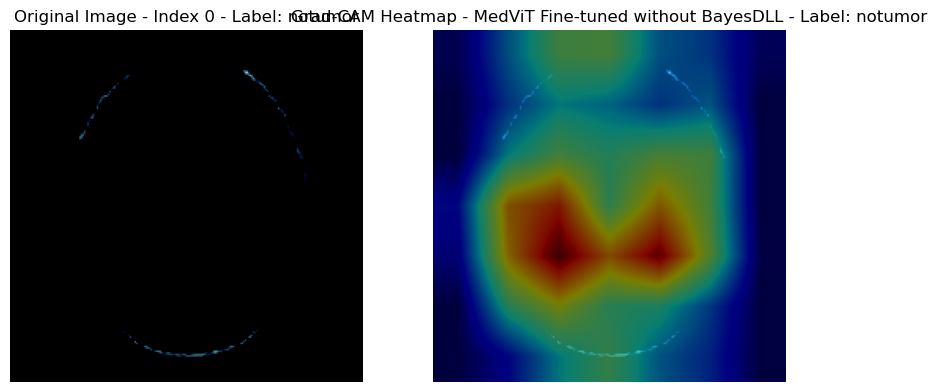

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


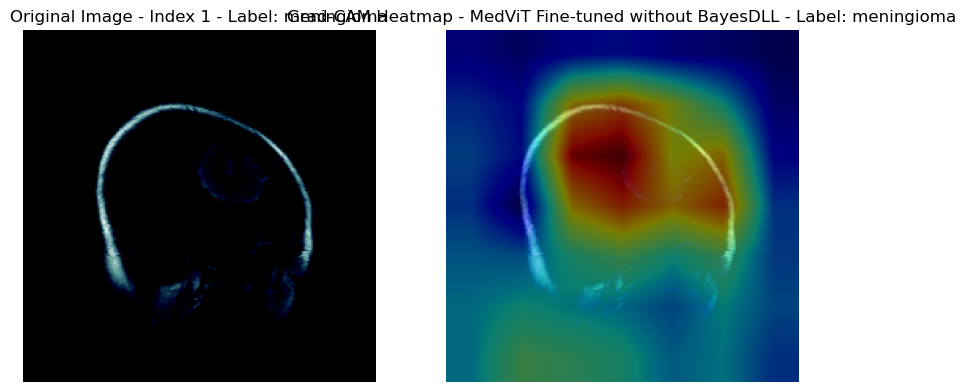

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].


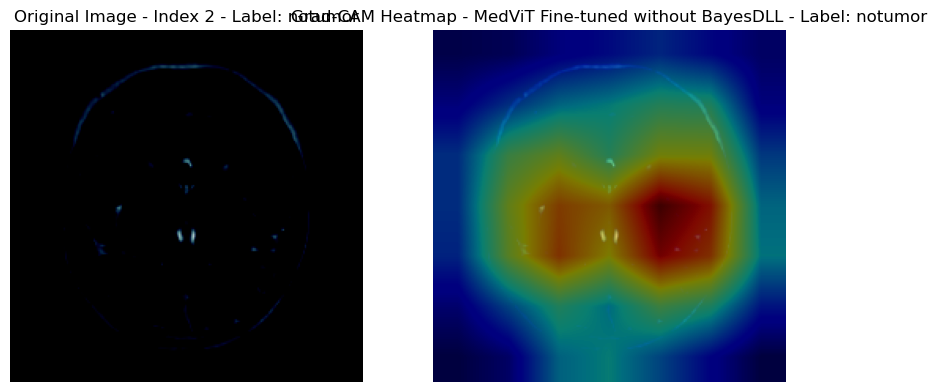

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].


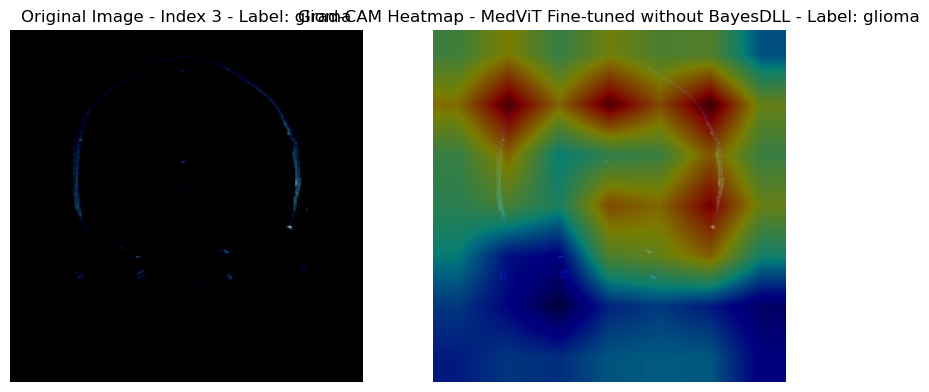

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].


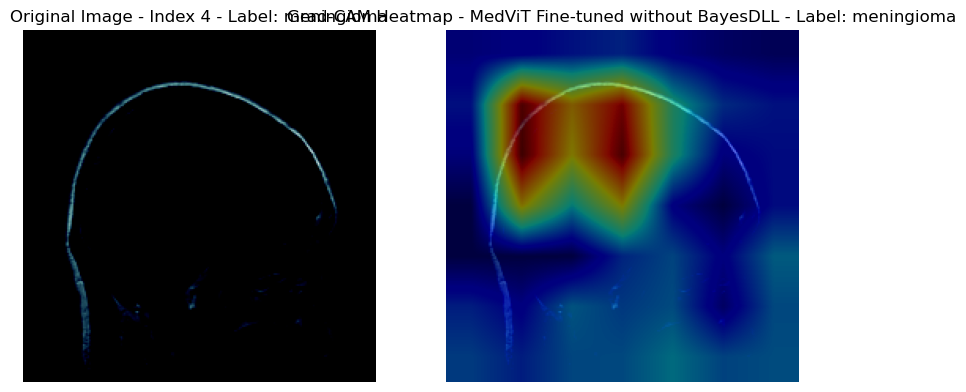

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8980392].


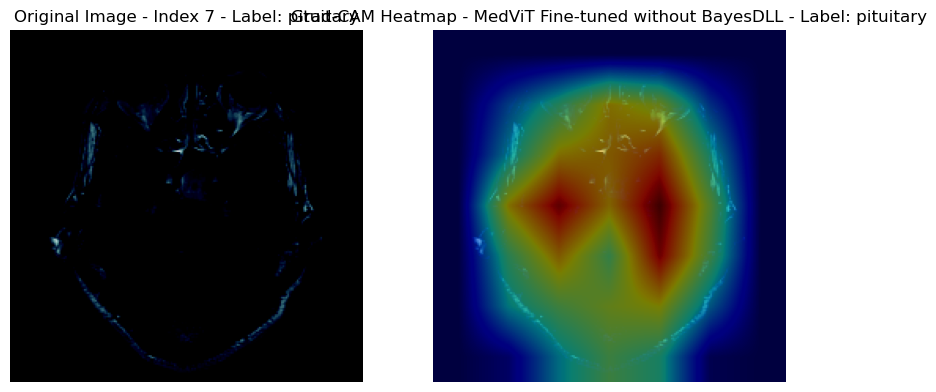

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].


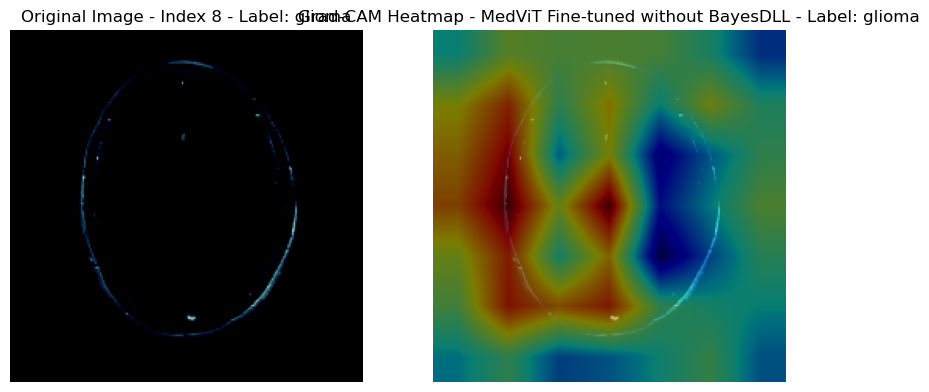

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].


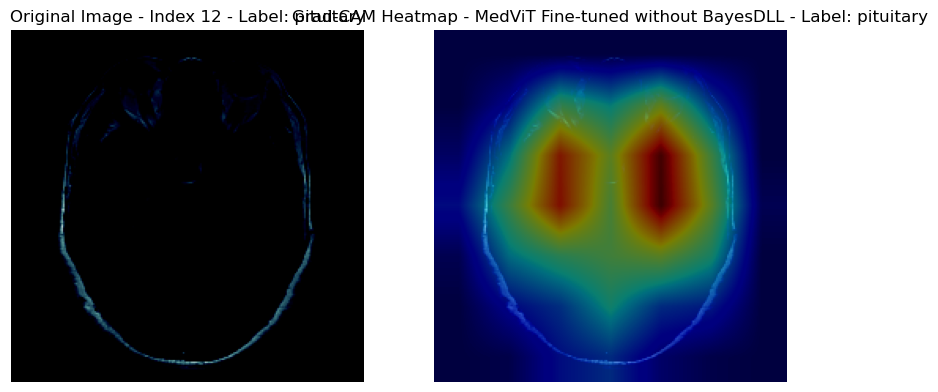

Sample indices used for Grad-CAM visualization: [0, 1, 2, 3, 4, 7, 8, 12]


In [14]:

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Hook to capture the activations and gradients
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def register_hooks(layer):
    layer.register_forward_hook(forward_hook)
    layer.register_full_backward_hook(backward_hook)

# Load the fine-tuned model from checkpoint
def load_finetuned_model_from_checkpoint(checkpoint_path, weights_path, num_classes):
    # Load the MedViT architecture
    model = MedViT_base(num_classes=1000).to(device)
    # Load the pre-trained weights first
    checkpoint = torch.load(weights_path)
    state_dict = checkpoint.get('model', checkpoint)
    state_dict = {k: v for k, v in state_dict.items() if 'proj_head.0' not in k}
    model.load_state_dict(state_dict, strict=False)

    # Adapt the projection head to the number of classes
    in_features = model.proj_head[0].in_features
    model.proj_head = nn.Linear(in_features, num_classes).to(device)

    # Load the fine-tuned model state from checkpoint
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded fine-tuned model from checkpoint: {checkpoint_path}")
    else:
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    return model

# Generate Grad-CAM heatmaps
def generate_gradcam_heatmap(model, input_image, target_layer_name='features.29.conv'):
    model.eval()
    input_image = input_image.unsqueeze(0).to(device)

    # Register hooks on the desired layer
    target_layer = dict(model.named_modules())[target_layer_name]
    register_hooks(target_layer)

    # Forward pass
    outputs = model(input_image)
    score = outputs[:, outputs.argmax(dim=1)].squeeze()

    # Backward pass to get gradients
    model.zero_grad()
    score.backward()

    global activations, gradients

    # Compute Grad-CAM
    gradients = gradients.cpu().data.numpy()
    activations = activations.cpu().data.numpy()

    # Weight the activations by the gradients
    weights = np.mean(gradients, axis=(2, 3))  # Average the gradients over the spatial dimensions
    cam = np.zeros(activations.shape[2:], dtype=np.float32)  # Initialize the CAM with the correct spatial dimensions

    # Sum over the channels
    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    cam = np.maximum(cam, 0)  # ReLU to keep only positive values
    cam = cv2.resize(cam, (224, 224))  # Resize to match input image size
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0 and 1
    return cam

# Plot the original image and Grad-CAM heatmap side by side
def plot_side_by_side(input_image, heatmap, label, index, model_name='MedViT Fine-tuned'):
    plt.figure(figsize=(10, 5))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.permute(1, 2, 0))
    plt.title(f"Original Image - Index {index} - Label: {label}")
    plt.axis('off')
    
    # Plot Grad-CAM heatmap on top of the original image
    plt.subplot(1, 2, 2)
    plt.imshow(input_image.permute(1, 2, 0))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM Heatmap - {model_name} - Label: {label}")
    plt.axis('off')
    
    plt.show()

# Load the fine-tuned model from the saved checkpoint
model = load_finetuned_model_from_checkpoint(checkpoint_path, weights_path, n_classes)

# Labels corresponding to the dataset, assuming you have a mapping like this
label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Set to keep track of how many samples we've collected for each label
label_count = {'glioma': 0, 'meningioma': 0, 'notumor': 0, 'pituitary': 0}
target_count_per_label = 2  # We want 2 images per label

logged_indices = []  # Keep track of the sample indices used

# Loop through the dataset until we have 2 images per label (total of 8 images)
i = 0
while len(logged_indices) < 8:
    sample_image, sample_label = val_dataset[i]  # Example sample from the validation set
    label_name = label_mapping[sample_label]  # No need for .item(), just use sample_label directly

    # Check if we already have 2 samples for this label
    if label_count[label_name] < target_count_per_label:
        # Generate the Grad-CAM heatmap for this sample
        heatmap = generate_gradcam_heatmap(model, sample_image)

        # Log the index and increase the count for this label
        logged_indices.append(i)
        label_count[label_name] += 1
        
        # Plot side-by-side comparison of original image and heatmap with label
        plot_side_by_side(sample_image, heatmap, label_name, i, model_name=f'MedViT Fine-tuned without BayesDLL')

    i += 1  # Move to the next sample

# After the loop, print the logged indices for later use
print("Sample indices used for Grad-CAM visualization:", logged_indices)


***IMPLEMENTING FINE TUNING OF MEDVIT WITH MRI DATASET LEVERAGING BAYESDLL***

In [11]:
import sys
sys.path.append('/home/ec2-user/ssl/BayesDLL')  # Make sure this path is correct


In [14]:
import torch
import logging
import os
import copy
import time
from types import SimpleNamespace
from sklearn.metrics import roc_auc_score, accuracy_score
from bayesdll.vi import Runner
from bayesdll import calibration
import numpy as np

# Function to create the MedViT backbone with pre-trained weights
def create_medvit_backbone(args):
    from MedViT import MedViT_base
    backbone = MedViT_base(num_classes=1000).to(args.device)

    if args.pretrained and os.path.isfile(args.pretrained):
        checkpoint = torch.load(args.pretrained, map_location=args.device)
        state_dict = checkpoint.get('model', checkpoint)
        state_dict = {k: v for k, v in state_dict.items() if 'proj_head.0' not in k}
        backbone.load_state_dict(state_dict, strict=False)
        print("Loaded pretrained MedViT weights successfully.")
    else:
        raise FileNotFoundError(f"Pre-trained weights file not found at: {args.pretrained}")

    in_features = backbone.proj_head[0].in_features
    backbone.proj_head = torch.nn.Linear(in_features, args.num_classes).to(args.device)
    backbone.readout_name = 'proj_head'
    return backbone

# Checkpoint functions
def save_checkpoint(epoch, model, optimizer, best_val_loss, filepath='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }, filepath)

def load_checkpoint(filepath='checkpoint.pth', model=None, optimizer=None):
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint loaded successfully from epoch {start_epoch}.")
        return start_epoch, best_val_loss
    else:
        print(f"No checkpoint found at {filepath}. Starting fresh training.")
        return 0, float('inf')

# Logger setup function
def setup_logger(log_dir='logs', log_filename='training_log.log'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    
    log_filepath = os.path.join(log_dir, log_filename)
    
    logger = logging.getLogger('training_logger')
    logger.setLevel(logging.INFO)
    
    # Create handlers
    file_handler = logging.FileHandler(log_filepath)
    console_handler = logging.StreamHandler()
    
    # Create formatters and add them to the handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

# Metric evaluation class, also calling BayesDLL for ECE, MCE, NLL
class MetricEvaluator:
    @staticmethod
    def compute_classification_metrics(targets, logits):
        probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()
        predictions = probabilities.argmax(axis=1)
        acc = accuracy_score(targets, predictions)
        auc = roc_auc_score(targets, probabilities, multi_class='ovr')
        return acc, auc

    @staticmethod
    def compute_calibration_metrics(targets, logits, args, epoch, is_test=False):
        ece, mce, nll = calibration.analyze(
            targets, logits, num_bins=args.ece_num_bins,
            plot_save_path=os.path.join(args.log_dir, f'reliability_epoch_{epoch + 1}_{"test" if is_test else "val"}.png')
        )
        return ece, mce, nll

# Training function with validation-only evaluations
def train_and_evaluate_model(args, train_loader, val_loader):
    logger = setup_logger()
    net = create_medvit_backbone(args)
    net0 = copy.deepcopy(net)  # For Bayesian learning with VI
    runner = Runner(net, net0, args, logger=logger)
    optimizer = torch.optim.AdamW(net.parameters(), lr=args.lr)

    # Load checkpoint if available
    start_epoch, best_val_loss = load_checkpoint(filepath='checkpoint.pth', model=net, optimizer=optimizer)

    evaluator = MetricEvaluator()
    epochs_without_improvement = 0
    start_time = time.time()

    for epoch in range(start_epoch, args.epochs):
        runner.train_one_epoch(train_loader)

        # Validate using only the validation set
        if (epoch + 1) % args.test_eval_freq == 0 or epoch == 0:
            val_loss, val_error, val_targets, val_logits, _ = runner.evaluate(val_loader)
            val_acc, val_auc = evaluator.compute_classification_metrics(val_targets, val_logits)
            
            # Compute calibration metrics
            ece, mce, nll = evaluator.compute_calibration_metrics(val_targets, val_logits, args, epoch)
            
            logger.info(f"Epoch {epoch + 1}/{args.epochs}: Validation Loss: {val_loss:.4f}, "
                        f"Validation ACC: {val_acc:.4f}, Validation AUC: {val_auc:.4f}, "
                        f"ECE: {ece:.4f}, MCE: {mce:.4f}, NLL: {nll:.4f}")

            # Save calibration plot after 10 epochs, and at the beginning
            if (epoch + 1) == 1 or (epoch + 1) % 10 == 0:
                plot_save_path = os.path.join(args.log_dir, f'reliability_epoch_{epoch + 1}.png')
                logger.info(f"Reliability plot saved at: {plot_save_path}")
            
            # Early stopping and checkpointing logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                save_checkpoint(epoch, net, optimizer, best_val_loss, filepath='checkpoint.pth')
                torch.save(net.state_dict(), 'best_model_bayesdll.pth')
                logger.info(f"New Best Validation AUC: {val_auc:.4f} achieved at epoch {epoch + 1}")

                # Save reliability plot for best model
                plot_save_path = os.path.join(args.log_dir, f'best_model_reliability_epoch_{epoch + 1}.png')
                logger.info(f"Reliability plot for the best model saved at: {plot_save_path}")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= args.patience:
                    logger.info(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
                    break

    end_time = time.time()
    training_duration = end_time - start_time
    logger.info(f"Training completed in {training_duration / 60:.2f} minutes.")

# Create arguments (args) for BayesDLL
def create_args(num_classes, num_train_samples, epochs=100, patience=10):
    return SimpleNamespace(
        dataset='mri_dataset',
        backbone='medvit_base',
        method='vi',
        hparams={'prior_sig': 1.0, 'kld': 1e-3, 'bias': 'informative', 'nst': 5},
        epochs=epochs,
        batch_size=32,
        lr=1e-4,
        lr_head=1e-4,
        momentum=0.5,
        seed=42,
        log_dir='results',
        device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
        use_cuda=torch.cuda.is_available(),
        pretrained='/home/ec2-user/ssl/MedViT/pretrained_weights/MedViT_base.pth',
        test_eval_freq=10,
        ece_num_bins=15,
        num_classes=num_classes,
        ND=num_train_samples,
        patience=patience
    )

# Main function to execute training
def main(train_loader, val_loader, num_classes, num_train_samples, epochs=100):
    args = create_args(num_classes, num_train_samples, epochs)
    train_and_evaluate_model(args, train_loader, val_loader)

In [15]:
# Run the training (ensure you load train and validation datasets appropriately)
main(train_loader, val_loader, n_classes, len(train_dataset), epochs=100)

initialize_weights...
Loaded pretrained MedViT weights successfully.
No checkpoint found at checkpoint.pth. Starting fresh training.


  0%|                                                                                                                                         | 0/125 [00:00<?, ?batch/s]/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1714328519311/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:38<00:00,  1.44s/batch, error=0.488, loss=1.2]
2024-10-12 20:55:49,645 - INFO - Epoch 1/100: Validation Loss: 1.2043, Validation ACC: 0.5123, Validation AUC: 0.7850, ECE: 0.0518, MCE: 0.3477, NLL: 1.2043
2024-10-12 20:55:49,646 - INFO - Relia

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:38<00:00,  1.43s/batch, error=0.0945, loss=0.311]
2024-10-12 21:55:52,724 - INFO - Epoch 40/100: Validation Loss: 0.3112, Validation ACC: 0.9055, Validation AUC: 0.9897, ECE: 0.0396, MCE: 0.1843, NLL: 0.3112
2024-10-12 21:55:52,724 - INFO - Reliability plot saved at: results/reliability_epoch_40.png
2024-10-12 21:55:54,703 - INFO - New Best Validation AUC: 0.9897 achieved at epoch 40
2024-10-12 21:55:54,704 - INFO - Reliability plot for the best model saved at: results/best_model_reliability_epoch_40.png
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:38<00:00,  1.43s/batch, error=0.0782, loss=0.276]
2024-10-12 22:11:15,029 - INFO - Epoch 50/100: Validation Loss: 0.2760, Validation ACC: 0.9218, Validation AUC: 0.9906, ECE: 0.0367, MCE: 0.1984, NLL: 0.2760
2024-10-12 22:11:15,030 - INFO - Reliabili

In [13]:
import torch
import numpy as np
import os
from sklearn.metrics import roc_auc_score, accuracy_score
from bayesdll import calibration
from types import SimpleNamespace

# Function to create the MedViT backbone with pre-trained weights
def create_medvit_backbone(args):
    from MedViT import MedViT_base
    backbone = MedViT_base(num_classes=1000).to(args.device)

    in_features = backbone.proj_head[0].in_features
    backbone.proj_head = torch.nn.Linear(in_features, args.num_classes).to(args.device)
    backbone.readout_name = 'proj_head'
    return backbone

# Metric evaluation class, also calling BayesDLL for ECE, MCE, NLL
class MetricEvaluator:
    @staticmethod
    def compute_classification_metrics(targets, logits):
        probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()
        predictions = probabilities.argmax(axis=1)
        acc = accuracy_score(targets, predictions)
        auc = roc_auc_score(targets, probabilities, multi_class='ovr')
        return acc, auc

    @staticmethod
    def compute_calibration_metrics(targets, logits, args, epoch=0, is_test=True):
        ece, mce, nll = calibration.analyze(
            targets, logits, num_bins=args.ece_num_bins,
            plot_save_path=os.path.join(args.log_dir, f'reliability_test.png')
        )
        return ece, mce, nll

# Function to evaluate on test set
def evaluate_on_test(test_loader, args):
    # Load the saved model
    model = create_medvit_backbone(args)
    model.load_state_dict(torch.load('best_model_bayesdll.pth'))  # Load the saved best model
    model.eval()

    # Variables to store test targets and logits
    test_targets, test_logits = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(args.device), targets.to(args.device)
            logits = model(inputs)
            test_targets.append(targets.cpu().numpy())
            test_logits.append(logits.cpu().numpy())

    # Concatenate all the test results
    test_targets = np.concatenate(test_targets)
    test_logits = np.concatenate(test_logits)

    # Compute final accuracy, AUC, and calibration metrics on the test set
    evaluator = MetricEvaluator()
    test_acc, test_auc = evaluator.compute_classification_metrics(test_targets, test_logits)
    ece, mce, nll = evaluator.compute_calibration_metrics(test_targets, test_logits, args)

    print(f"Test ACC: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
    print(f"Test ECE: {ece:.4f}, Test MCE: {mce:.4f}, Test NLL: {nll:.4f}")
    print(f"Reliability plot for the test set saved at: {os.path.join(args.log_dir, 'reliability_test.png')}")

# Recreate the `args` object with the same parameters used in training
def create_args(num_classes, num_train_samples, log_dir='results', device='cuda'):
    return SimpleNamespace(
        dataset='mri_dataset',
        backbone='medvit_base',
        method='vi',
        hparams={'prior_sig': 1.0, 'kld': 1e-3, 'bias': 'informative', 'nst': 5},
        batch_size=32,
        ece_num_bins=15,
        num_classes=num_classes,
        ND=num_train_samples,
        log_dir=log_dir,
        device=torch.device(device) if torch.cuda.is_available() else torch.device('cpu'),
    )


num_classes = 4  
num_train_samples = 1000  

# Recreate the `args` object
args = create_args(num_classes, num_train_samples)

# Now, run the test evaluation
evaluate_on_test(test_loader, args)


initialize_weights...
Test ACC: 0.9078, Test AUC: 0.9895
Test ECE: 0.0102, Test MCE: 0.1667, Test NLL: 0.2573
Reliability plot for the test set saved at: results/reliability_test.png


***Creating Reliability Plots***

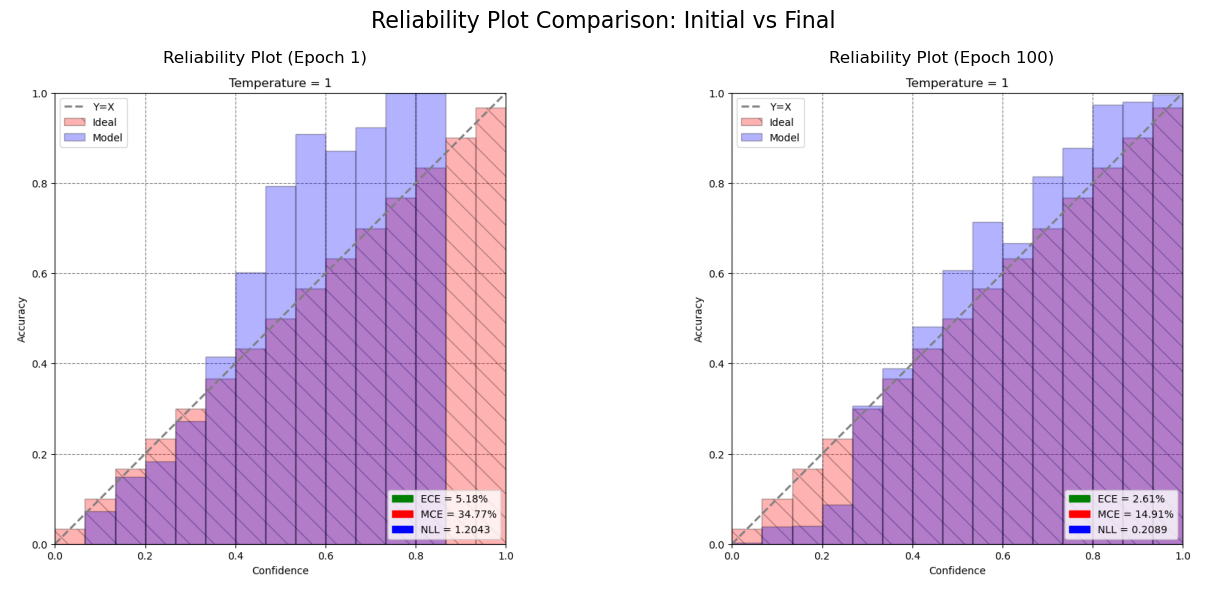

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the initial reliability plot (before fine-tuning)
initial_plot_path = 'results/reliability_epoch_1_val.png'  # Make sure this path is correct

# Path to the final reliability plot (after fine-tuning, on the test set)
final_plot_path = 'results/reliability_epoch_100_val.png'  # This is the final test set plot

# Load the images
initial_img = mpimg.imread(initial_plot_path)
final_img = mpimg.imread(final_plot_path)

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Display the initial plot (before fine-tuning)
axes[0].imshow(initial_img)
axes[0].axis('off')  # Hide axes for cleaner display
axes[0].set_title('Reliability Plot (Epoch 1)')

# Display the final plot (after fine-tuning)
axes[1].imshow(final_img)
axes[1].axis('off')  # Hide axes for cleaner display
axes[1].set_title('Reliability Plot (Epoch 100)')

# Show the side-by-side comparison
plt.suptitle('Reliability Plot Comparison: Initial vs Final', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#CODE TO CREATE HEAT MAPS FOR PREDICTIONS OF BAYESIAN FINE TUNED MEDVIT MODEL
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from bayesdll.vi import Runner
import torch.nn as nn
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hook to capture the activations and gradients
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def register_hooks(layer):
    layer.register_forward_hook(forward_hook)
    layer.register_full_backward_hook(backward_hook)

# Load the fine-tuned model (with BayesDLL) from checkpoint
def load_finetuned_model_from_checkpoint_bayesdll(checkpoint_path, weights_path, num_classes):
    from MedViT import MedViT_base
    # Load MedViT model
    model = MedViT_base(num_classes=1000).to(device)
    # Load pre-trained weights for MedViT
    checkpoint = torch.load(weights_path)
    state_dict = checkpoint.get('model', checkpoint)
    state_dict = {k: v for k, v in state_dict.items() if 'proj_head.0' not in k}
    model.load_state_dict(state_dict, strict=False)
    
    # Modify the projection head to match the number of classes
    in_features = model.proj_head[0].in_features
    model.proj_head = nn.Linear(in_features, num_classes).to(device)
    
    # Load BayesDLL fine-tuned checkpoint (which is directly a state dict)
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)  # No need for 'model_state_dict' key, directly load the state dict
        print(f"Loaded fine-tuned BayesDLL model from checkpoint: {checkpoint_path}")
    else:
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    return model


# Generate Grad-CAM heatmaps
def generate_gradcam_heatmap_bayesdll(model, input_image, target_layer_name='features.29.conv'):
    model.eval()
    input_image = input_image.unsqueeze(0).to(device)

    # Register hooks on the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    register_hooks(target_layer)

    # Forward pass
    outputs = model(input_image)
    score = outputs[:, outputs.argmax(dim=1)].squeeze()

    # Backward pass to get gradients
    model.zero_grad()
    score.backward()

    global activations, gradients

    # Compute Grad-CAM
    gradients = gradients.cpu().data.numpy()
    activations = activations.cpu().data.numpy()

    # Weight the activations by the gradients
    weights = np.mean(gradients, axis=(2, 3))  # Average the gradients over the spatial dimensions
    cam = np.zeros(activations.shape[2:], dtype=np.float32)  # Initialize the CAM with the correct spatial dimensions

    # Sum over the channels
    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    cam = np.maximum(cam, 0)  # ReLU to keep only positive values
    cam = cv2.resize(cam, (224, 224))  # Resize to match input image size
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0 and 1
    return cam

# Plot the original image and Grad-CAM heatmap side by side
def plot_side_by_side_bayesdll(input_image, heatmap, label, index, model_name='MedViT Fine-tuned with BayesDLL'):
    plt.figure(figsize=(10, 5))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.permute(1, 2, 0))
    plt.title(f"Original Image - Index {index} - Label: {label}")
    plt.axis('off')
    
    # Plot Grad-CAM heatmap on top of the original image
    plt.subplot(1, 2, 2)
    plt.imshow(input_image.permute(1, 2, 0))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM Heatmap - {model_name} - Label: {label}")
    plt.axis('off')
    
    plt.show()

# Define paths for checkpoint and pre-trained weights
weights_path = '/home/ec2-user/ssl/MedViT/pretrained_weights/MedViT_base.pth'
checkpoint_path = 'best_model_bayesdll.pth'  # Path to the BayesDLL fine-tuned checkpoint

# Load the fine-tuned BayesDLL model
bayesdll_model = load_finetuned_model_from_checkpoint_bayesdll(
    checkpoint_path=checkpoint_path, 
    weights_path=weights_path, 
    num_classes=n_classes
)

# Labels corresponding to the dataset, assuming you have a mapping like this
label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Set to keep track of how many samples we've collected for each label
label_count = {'glioma': 0, 'meningioma': 0, 'notumor': 0, 'pituitary': 0}
target_count_per_label = 2  # We want 2 images per label

# Same indices used in the previous Grad-CAM analysis
logged_indices = [0, 1, 2, 3, 6, 9, 11, 12] # These are just example indices from previous run

# Loop through the dataset and generate heatmaps for the specific 8 images
for idx in logged_indices:
    sample_image, sample_label = val_dataset[idx]  # Get sample image and label from the validation set
    label_name = label_mapping[sample_label]

    # Generate the Grad-CAM heatmap for this sample
    heatmap = generate_gradcam_heatmap_bayesdll(bayesdll_model, sample_image)

    # Plot side-by-side comparison of original image and heatmap with label
    plot_side_by_side_bayesdll(sample_image, heatmap, label_name, idx, model_name='MedViT Fine-tuned with BayesDLL')

# After running the above, the heatmap analysis will be generated for the same 8 samples as before.


***References***

* MedViT: A Robust Vision Transformer for Generalized Medical Image Classification: https://github.com/Omid-Nejati/MedViT

* BayesDLL: Bayesian Deep Learning Library: https://github.com/SamsungLabs/BayesDLL/tree/main